In [1]:
!pip install pandas tensorflow matplotlib scikit-learn opendatasets

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow.keras as keras
import os
import opendatasets as od
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [3]:
KAGGLE_LINK = "https://www.kaggle.com/datasets/kritanjalijain/outfititems"
DATASET_PATH = "./outfititems/train/train/accessories/bag"

IMAGE_WIDTH = 150
IMAGE_HEIGHT = 150

In [4]:
od.download(KAGGLE_LINK, force=False)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: A
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/kritanjalijain/outfititems


100%|██████████| 6.48G/6.48G [01:37<00:00, 71.2MB/s]


In [5]:
images = []

list_dir = os.listdir(DATASET_PATH)

for i, filename in enumerate(list_dir):
  image = load_img(os.path.join(DATASET_PATH, filename), target_size=(IMAGE_WIDTH, IMAGE_HEIGHT))
  image = img_to_array(image)
  images.append(image)

In [6]:
# Preprocess Images
images = np.asarray(images).astype(np.float32) / 255.0

x_train = images[:-10]
x_test = images[-10:]

In [7]:
# Define Hyperparameters
BATCH_SIZE = 32
IMAGE_ORIGINAL_SHAPE = x_train.shape[1:]
IMAGE_SIZE = IMAGE_ORIGINAL_SHAPE[0] * IMAGE_ORIGINAL_SHAPE[1] * IMAGE_ORIGINAL_SHAPE[2]
HIDDEN_DIM = 512
LATENT_DIM = 32
MAX_EPOCHS = 20
LEARNING_RATE = 0.0001

In [8]:
# Model Creation
class VAE(tf.keras.Model):
  def __init__(self, dim, **kwargs):
    super(VAE, self).__init__(**kwargs)

    h_dim = dim[0]
    z_dim = dim[1]

    self.fc1 = tf.keras.layers.Dense(h_dim, activation=tf.nn.relu)
    self.fc2 = tf.keras.layers.Dense(z_dim)
    self.fc3 = tf.keras.layers.Dense(z_dim)
    self.fc4 = tf.keras.layers.Dense(h_dim)
    self.fc5 = tf.keras.layers.Dense(IMAGE_SIZE)

    self.encoder_batch_norm = tf.keras.layers.BatchNormalization()
    self.decoder_batch_norm = tf.keras.layers.BatchNormalization()

  def build(self, input_shape):
    super(VAE, self).build(input_shape)

  def encode(self, x):
    x = self.encoder_batch_norm(x)
    h = self.fc1(x)
    return self.fc2(h), self.fc3(h)

  def decode_logits(self, z):
    h = self.fc4(z)
    h = self.fc5(h)
    return self.decoder_batch_norm(h)

  def decode(self, z):
    return tf.nn.sigmoid(self.decode_logits(z))

  def reparameterize(self, mu, log_var):
    std = tf.exp(log_var * 0.5)
    eps = tf.random.normal(std.shape)
    return mu + eps * std

  def call(self, input, training=None, mask=None):
    mu, log_var = self.encode(input)
    z = self.reparameterize(mu, log_var)
    x_recon_logits = self.decode_logits(z)
    return x_recon_logits, mu, log_var

In [9]:
tf.keras.backend.clear_session()
model = VAE([HIDDEN_DIM, LATENT_DIM])

dummy_input = tf.random.normal((BATCH_SIZE, IMAGE_SIZE))
model(dummy_input)

print(model.summary())

Model: "vae"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (32, 512)                   │      34,560,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (32, 32)                    │          16,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (32, 32)                    │          16,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (32, 512)                   │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (32, 67500)                 │      34,627,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (32, 67500)                 │         270,000 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (32, 67500)                 │         270,000 │
│ (BatchNormalization)                 │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 69,777,740 (266.18 MB)

 Trainable params: 69,507,740 (265.15 MB)

 Non-trainable params: 270,000 (1.03 MB)

None


In [10]:
optimizers = tf.keras.optimizers.Adam(LEARNING_RATE)

dataset = tf.data.Dataset.from_tensor_slices(x_train)
dataset = dataset.shuffle(BATCH_SIZE * 5).batch(BATCH_SIZE)

In [11]:
loss_history = []
kl_div_history = []

num_batches = x_train.shape[0] // BATCH_SIZE

for epoch in range(MAX_EPOCHS):
  for x in dataset:
    x = tf.reshape(x, [-1, IMAGE_SIZE])

    with tf.GradientTape() as tape:
      x_reconstruction_logits, mu, log_var = model(x)

      reconstruction_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=x, logits=x_reconstruction_logits)

      reconstruction_loss = tf.reduce_sum(reconstruction_loss) / BATCH_SIZE

      kl_div = -0.5 * tf.reduce_sum(1. + log_var - tf.square(mu) - tf.exp(log_var), axis=-1)
      kl_div = tf.reduce_mean(kl_div)

      loss = tf.reduce_mean(reconstruction_loss + kl_div)

    gradients = tape.gradient(loss, model.trainable_variables)

    for g in gradients:
      tf.clip_by_norm(g, 15)

    optimizers.apply_gradients(zip(gradients, model.trainable_variables))

  loss_history.append(float(reconstruction_loss))
  kl_div_history.append(float(kl_div))
  print(f"Epoch: [{epoch}/{MAX_EPOCHS}] | Recon Loss: {float(reconstruction_loss):.2f} | KLDiv: {float(kl_div):.2f} | Loss: {float(loss):.2f}")

Epoch: [0/20] | Recon Loss: 3850.11 | KLDiv: 993.65 | Loss: 4843.76
Epoch: [1/20] | Recon Loss: 2467.42 | KLDiv: 738.06 | Loss: 3205.48
Epoch: [2/20] | Recon Loss: 2948.35 | KLDiv: 507.65 | Loss: 3456.00
Epoch: [3/20] | Recon Loss: 2915.61 | KLDiv: 431.76 | Loss: 3347.37
Epoch: [4/20] | Recon Loss: 3186.44 | KLDiv: 338.96 | Loss: 3525.40
Epoch: [5/20] | Recon Loss: 2831.50 | KLDiv: 336.96 | Loss: 3168.46
Epoch: [6/20] | Recon Loss: 2410.05 | KLDiv: 380.38 | Loss: 2790.43
Epoch: [7/20] | Recon Loss: 3354.09 | KLDiv: 284.50 | Loss: 3638.59
Epoch: [8/20] | Recon Loss: 2817.90 | KLDiv: 257.26 | Loss: 3075.16
Epoch: [9/20] | Recon Loss: 2581.31 | KLDiv: 242.32 | Loss: 2823.63
Epoch: [10/20] | Recon Loss: 3081.87 | KLDiv: 207.18 | Loss: 3289.05
Epoch: [11/20] | Recon Loss: 2875.30 | KLDiv: 191.49 | Loss: 3066.79
Epoch: [12/20] | Recon Loss: 2580.08 | KLDiv: 205.74 | Loss: 2785.82
Epoch: [13/20] | Recon Loss: 2755.11 | KLDiv: 240.51 | Loss: 2995.62
Epoch: [14/20] | Recon Loss: 2057.77 | KLDiv

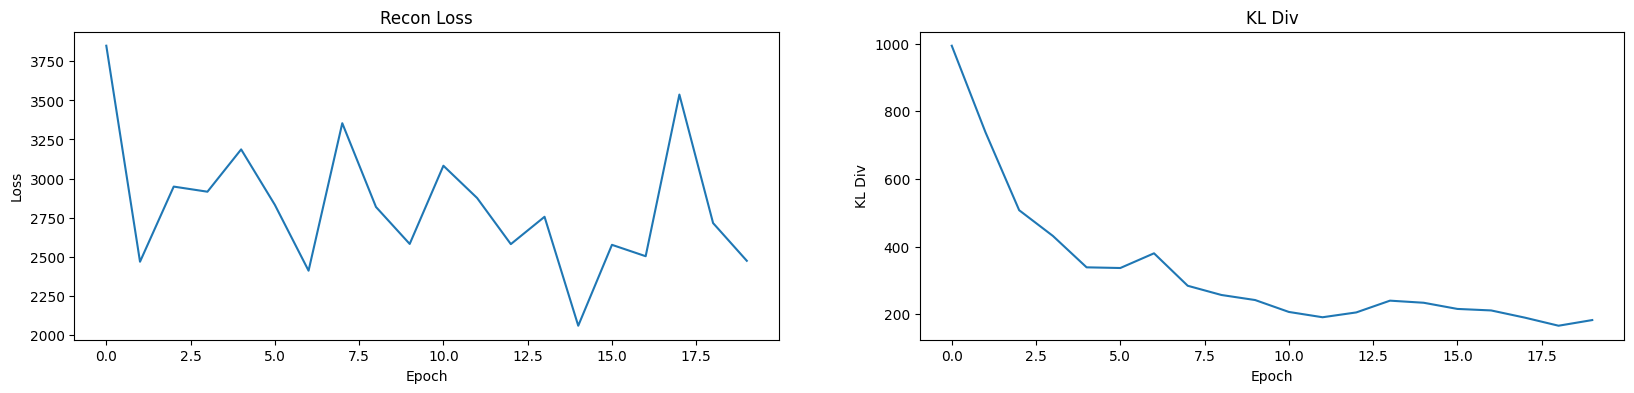

In [17]:
plt.figure(figsize=(20, 4))
plt.subplot(1, 2, 1)
plt.title("Recon Loss")
plt.plot(loss_history)
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1, 2, 2)
plt.title("KL Div")
plt.plot(kl_div_history)
plt.xlabel("Epoch")
plt.ylabel("KL Div")

plt.show()

In [18]:
def get_out_from_z(z):
  out = model.decode(z)
  out = tf.reshape(out, (-1, IMAGE_ORIGINAL_SHAPE[0], IMAGE_ORIGINAL_SHAPE[1], IMAGE_ORIGINAL_SHAPE[2]))
  return out

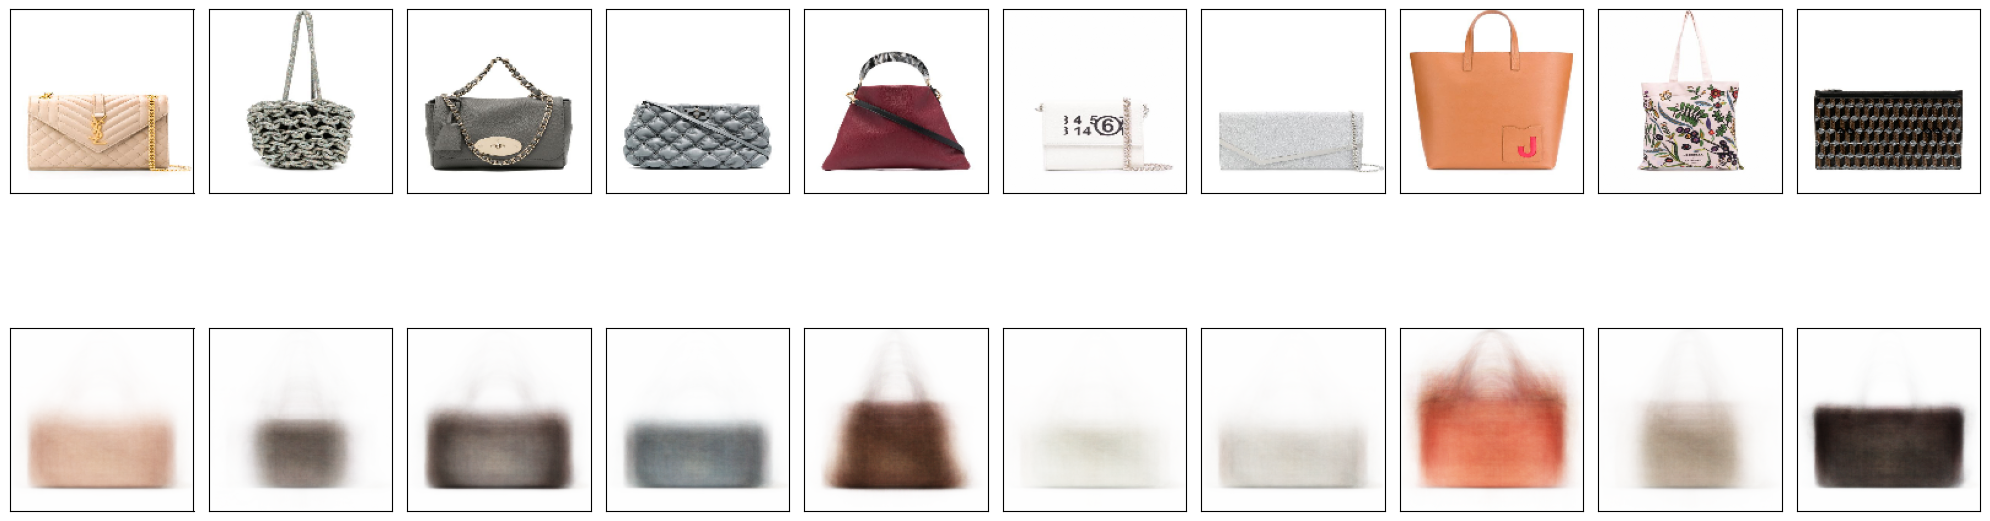

In [19]:
mu, log_var = model.encode(x_test.reshape(-1, IMAGE_SIZE))
z = model.reparameterize(mu, log_var)
out = get_out_from_z(z)

number = 10
plt.figure(figsize=(20, 8))
for i in range(number):
  ax = plt.subplot(2, number, i + 1)
  plt.imshow(x_test[i].reshape(IMAGE_ORIGINAL_SHAPE), cmap="gray")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

for i in range(number):
  ax = plt.subplot(2, number, number + i + 1)
  plt.imshow(out[i], cmap="gray")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

plt.tight_layout()
plt.show()

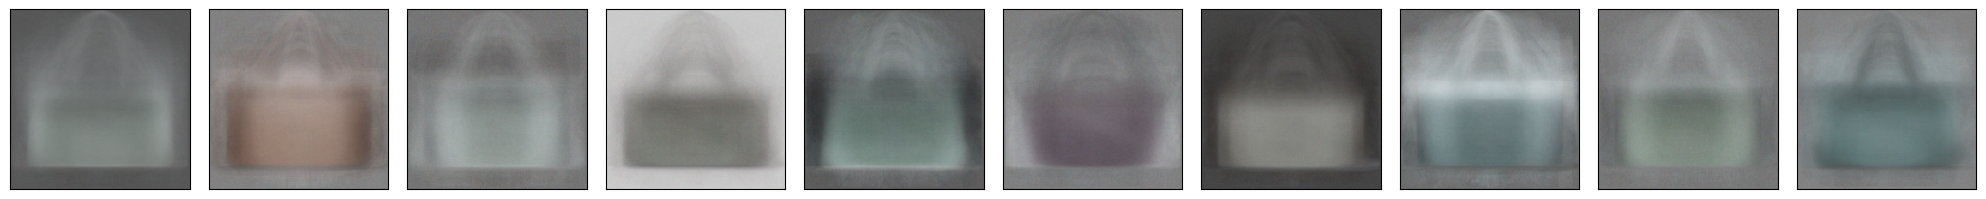

In [20]:
z = tf.random.normal([BATCH_SIZE, LATENT_DIM])

out = get_out_from_z(z)

number = 10
plt.figure(figsize=(20, 4))
for i in range(number):
  ax = plt.subplot(2, number, i + 1)
  plt.imshow(out[i], cmap="gray")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

plt.tight_layout()
plt.show()

In [22]:
model.save("VAE.h5")